## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from surfer import Brain
from mayavi import mlab

# from tvtk.api import tvtk
# from tvtk.common import configure_input_data

mlab.init_notebook()
mlab.options.offscreen = True

%matplotlib inline

#%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config

sys.path.append('../')
from lib.plot_utils import *
from lib.data_stats import aggregate_perf

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/config


### Brainmap plot configs

In [3]:
analysis_type = 'ml' #sm or ml
results_type = 'Software' # atlas or Software
qc_type = 'auto'  #'gleb' #'maarten' #'No_QC' # 'auto'

### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Data paths

In [26]:
proj_dir = '/home/nikhil/projects/CT_reproduce/'
data_dir = proj_dir + 'code/compare-surf-tools/data/'
plot_results_dir = proj_dir + 'data/results/'

common_space = proj_dir + 'code/compare-surf-tools/config/fsaverage/'

demograph_file = 'ABIDE_Phenotype.csv'

# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})


if analysis_type == 'sm':
    results_dir = plot_results_dir + 'sm/'
    
    outcome_var = 'roi' #'DX_GROUP'
    predictor_var = 'AGE_AT_SCAN' #'DX_GROUP'
    stat_measure = 'p_val_corr' # p_val or p_val_corr
    stat_thresh = 0.05

    if outcome_var == 'DX_GROUP':
        model_type = 'logit'
    elif outcome_var in ['AGE_AT_SCAN','roi']:
        model_type = 'ols'
    else:
        print('Unknown outcome variable {}'.format(outcome_var))


    #pipelines_sm_perf_DKT_test_AGE_AT_SCAN_roi_ols_QC_manual_maarten_N_748.pkl
    if results_type == 'Software':
        if qc_type == 'auto':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_auto_N_683.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'maarten':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_manual_lenient_N_748.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'gleb':
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_manual_stringent_N_194.pkl'.format(outcome_var,predictor_var,model_type)
        else:
            sm_perf_file = 'Software_DKT_sm_perf_{}_{}_{}_QC_No_QC_N_778.pkl'.format(outcome_var,predictor_var,model_type)

    else: 
        if qc_type == 'auto':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_auto_N_959.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'maarten':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_manual_lenient_N_975.pkl'.format(outcome_var,predictor_var,model_type)
        elif qc_type == 'gleb':
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_manual_stringent_N_225.pkl'.format(outcome_var,predictor_var,model_type)
        else:
            sm_perf_file = 'Atlas_FS6.0_sm_perf_{}_{}_{}_QC_No_QC_N_1047.pkl'.format(outcome_var,predictor_var,model_type)


    print('Using following configs: \n outcome variable: {}\n predictor var: {}\n results_type: {}\n model_type: {}\n qc_type: {}\n'.format(outcome_var,
                                                                                                                        predictor_var,
                                                                                                                        results_type,
                                                                                                                        model_type,
                                                                                                                        qc_type))
    print('Perf file used: {}'.format(sm_perf_file))

    if stat_measure == 'p_val':
        mult_comp = 'no_FDR'
    elif stat_measure == 'p_val_corr':
        mult_comp = 'FDR'
    else:
        print('unknown multiple comparison correction')
        mult_comp = 'unknown'


    sm_perf_filename_split = sm_perf_file.rsplit('.',1)[0].rsplit('_',2) 
    brainmap_subdir = sm_perf_filename_split[0] + '_{}_'.format(mult_comp) + sm_perf_filename_split[1] + '_' + sm_perf_filename_split[2]
    subx = sm_perf_file.rsplit('_',1)[1].split('.',1)[0]
    suffix = subx
    
    if results_type == 'pipeline':
        stat_perf = pd.read_pickle(results_dir + sm_perf_file)

    else:
        with open(results_dir + sm_perf_file, 'rb') as handle:
            stat_perf = pickle.load(handle)

elif analysis_type == 'ml':
    results_dir = plot_results_dir + 'ml/'
    outcome_var = 'AGE_AT_SCAN'
    results_type = 'Software' # atlas or pipeline
    qc_type = 'No_QC'  #'gleb' #'maarten' #'No_QC' # 'auto'
    dx = 0
    stat_thresh = 2 #Only want rank==1 (<2)
    
    stat_measure = 'rank'

    if outcome_var == 'DX_GROUP':
        model_type = 'classification'
    elif outcome_var == 'AGE_AT_SCAN':
        model_type = 'regression'
    else:
        print('Unknown outcome variable {}'.format(outcome_var))
    
    if results_type == 'Software':
        ml_perf_file = 'Software_DKT_ml_feature_imp_{}_{}_shuffle_split.pkl'.format(outcome_var,model_type)
        
    
    print('Analysis type: {}\n'.format(analysis_type))
    print('Using following configs: \n outcome variable: {}\n results_type: {}\n model_type: {}\n qc_type: {}\n'.format(outcome_var,
                                                                                                                        results_type,
                                                                                                                        model_type,
                                                                                                                        qc_type))
    print('Perf file used: {}'.format(ml_perf_file))
    ml_perf_filename_split = ml_perf_file.rsplit('.',1)[0].rsplit('_',1) 
    brainmap_subdir = ml_perf_filename_split[0] + '_Dx_{}_QC_{}'.format(dx,qc_type)
    suffix = 'Dx_{}'.format(dx)
    
    if results_type == 'Software':
        stat_perf_long = pd.read_pickle(results_dir + ml_perf_file)
        stat_perf = stat_perf_long[(stat_perf_long['DX_GROUP']==dx) & (stat_perf_long['qc']==qc_type)]

    else:
        with open(results_dir + ml_perf_file, 'rb') as handle:
            stat_perf = pickle.load(handle)
    
else:
    print('Unknown analysis type')

brainmaps_dir = results_dir + 'brainmaps/'
save_dir = brainmaps_dir + brainmap_subdir + '/'
print('Save dir for brainmap plots: {}'.format(save_dir))

Analysis type: ml

Using following configs: 
 outcome variable: AGE_AT_SCAN
 results_type: Software
 model_type: regression
 qc_type: No_QC

Perf file used: Software_DKT_ml_feature_imp_AGE_AT_SCAN_regression_shuffle_split.pkl
Save dir for brainmap plots: /home/nikhil/projects/CT_reproduce/data/results/ml/brainmaps/Software_DKT_ml_feature_imp_AGE_AT_SCAN_regression_shuffle_Dx_0_QC_No_QC/


### Statistical plots 

Top 5 most significant regions                        roi  rank  grid_scores software  DX_GROUP     qc
30      R_inferiortemporal     1   -33.108627    FS5.1         0  No_QC
7       L_superiortemporal     1   -33.286450    FS5.1         0  No_QC
9   R_lateralorbitofrontal     1   -33.161011    FS5.1         0  No_QC
12      L_inferiorparietal     1   -33.103422    FS5.1         0  No_QC
13             R_precuneus     1   -33.112683    FS5.1         0  No_QC


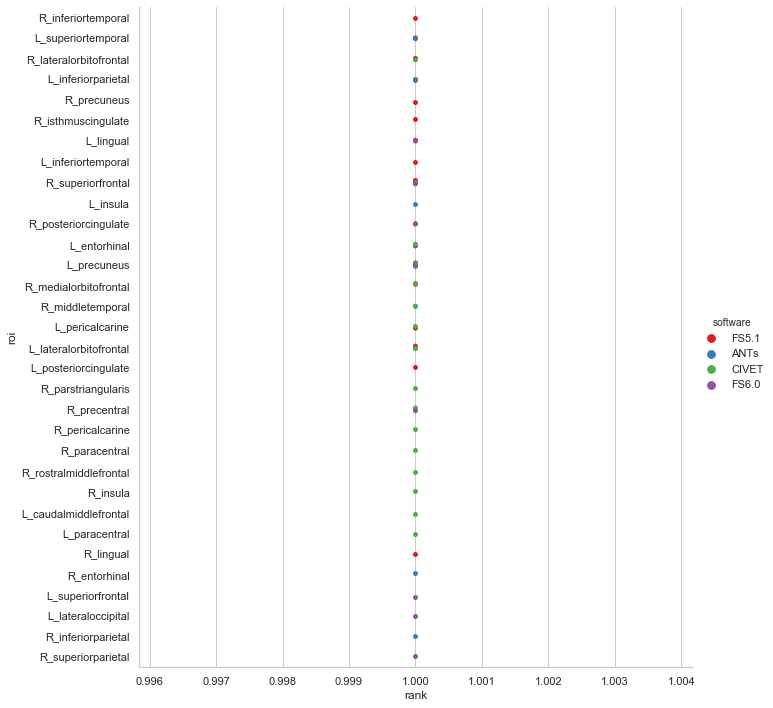

In [27]:
aparc = 'DKT' #DKT #Destrieux #Glasser
top_rois = 50

if results_type == 'Software':
    plot_df = stat_perf.sort_values(by=[stat_measure]).head(top_rois)
    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',hue='software',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");

else:
    plot_df = stat_perf[aparc].sort_values(by=['p_val']).head(top_rois)

    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");
        
print('Top 5 most significant regions {}'.format(plot_df.head(5)))

## PySurfer plots

In [28]:
# Plot configs

if results_type == 'Software':
    pipes = list(stat_perf['software'].unique())
    aparcs = ['DKT']

else:
    pipes = ['FS60']
    pipe = 'FS60' #For aggregating result cell 
    aparcs = list(stat_perf.keys()) #['aparc', 'Destrieux', 'Glasser']
    
# Pysurfer parameters
surf = 'inflated' #'white' #"inflated"
views = ['lateral','medial']

In [30]:
# Plot loops 
#plot_style = {'colormap':'icefire','center':0}
cmap = 'coolwarm'
plot_style = {'colormap':cmap,'center':0}

for pipe in pipes:
    for aparc in aparcs:
        if results_type == 'Software':            
            stat_df = stat_perf[stat_perf['software']==pipe]
        else:
            stat_df = stat_perf[aparc]
        
        signific_rois = stat_df[stat_df[stat_measure] < stat_thresh]['roi'].values
#         signific_betas = stat_df[stat_df[stat_measure] < stat_thresh]['coef'].values
        signific_betas = stat_df[stat_df[stat_measure] < stat_thresh]['rank'].values #for roi importance

        print('\nPipeline {}, parcellation {}, number of signficant ROIs {}'.format(pipe, aparc,len(signific_rois)))

        plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(signific_rois,aparc,signific_betas)
        print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))
        
        
        if aparc == 'Glasser':
            aparc_file = '.HCP-MMP1.annot' 
        elif aparc == 'Destrieux':
            aparc_file = '.aparc.a2009s.annot' 
        elif aparc == 'aparc':
            aparc_file = '.aparc.annot'
        elif aparc in 'DKT':
            aparc_file = '.aparc.DKTatlas40.annot'
        else:
            aparc_file = ''
            print('Unknown cortical parcellation')

        for hemi in ['lh', 'rh']:
            if hemi=='lh':
                signific_rois = plot_regions_L
                betas = betas_L
            elif hemi=='rh':
                signific_rois = plot_regions_R
                betas = betas_R
            else: 
                print('Unknown hemisphere parameter')

            for view in views:
                title = '_{}_{}_{}_{}_{}_{}_N_{}'.format(pipe,aparc,surf,hemi,view,stat_measure,suffix)
                brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                                save_dir,title,view,betas,plot_style)
                time.sleep(5) #Mayavi messes up if called to quickly
                


Pipeline ANTs, parcellation DKT, number of signficant ROIs 13
plot regions 
left: ['paracentral', 'superiortemporal', 'inferiorparietal', 'lingual', 'entorhinal', 'precuneus', 'insula'], 
right: ['inferiorparietal', 'paracentral', 'transversetemporal', 'postcentral', 'entorhinal', 'middletemporal']
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 7
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 125549, 1.0: 38293}
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/ml/brainmaps/Software_DKT_ml_feature_imp_AGE_AT_SCAN_regression_shuffle_Dx_0_QC_No_QC/surf_ANTs_DKT_inflated_lh_lateral_rank_N_Dx_0.png
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 7
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 125549, 1.0: 38293}
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (

Image saved at /home/nikhil/projects/CT_reproduce/data/results/ml/brainmaps/Software_DKT_ml_feature_imp_AGE_AT_SCAN_regression_shuffle_Dx_0_QC_No_QC/surf_FS5.3_DKT_inflated_rh_medial_rank_N_Dx_0.png

Pipeline FS6.0, parcellation DKT, number of signficant ROIs 20
plot regions 
left: ['posteriorcingulate', 'paracentral', 'inferiorparietal', 'cuneus', 'isthmuscingulate', 'superiorfrontal', 'medialorbitofrontal', 'lateraloccipital', 'lingual', 'precuneus', 'precentral'], 
right: ['precuneus', 'parstriangularis', 'superiorfrontal', 'posteriorcingulate', 'precentral', 'superiorparietal', 'medialorbitofrontal', 'rostralmiddlefrontal', 'lingual']
number of total vertices 163842 and ROIs 36
Using betas as colormap
number of significant rois 11
atlas: .aparc.DKTatlas40.annot, signficant roi count: {0.0: 100727, 1.0: 63115}
colormap divergent: center=0.00e+00, [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
Image saved at /home/nikhil/projects/CT_reproduce/data/results/ml/brainmaps/Software_DKT_ml_featur

### Aggregate results

In [33]:
if results_type == 'Software':
    df_agg = aggregate_perf(stat_perf,stat_measure,stat_thresh)
    
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('\n Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    n_colors = 6 # for 0-5 ranks
    #cmap = plt.get_cmap('Blues',n_colors) #plt.get_cmap('Pastel1_r',n_colors) #plt.get_cmap('tab20b',n_colors) #sns.xkcd_palette(["very light pink",'red'])  #plt.get_cmap('Set1')
    cmap = plt.get_cmap('Reds',n_colors)
    plot_style = {'colormap':cmap,'range':[0,n_colors-1]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}_N_{}'.format('zagg',aparc,surf,hemi,view,stat_measure,suffix)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)

../lib/data_stats.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['significance'] = df[measure] < thresh



 Number of signficant ROIs 62
plot regions 
left: ['postcentral', 'posteriorcingulate', 'lateralorbitofrontal', 'pericalcarine', 'paracentral', 'caudalanteriorcingulate', 'superiortemporal', 'rostralanteriorcingulate', 'inferiorparietal', 'cuneus', 'isthmuscingulate', 'superiorparietal', 'superiorfrontal', 'fusiform', 'parstriangularis', 'medialorbitofrontal', 'parahippocampal', 'lateraloccipital', 'lingual', 'inferiortemporal', 'transversetemporal', 'entorhinal', 'precuneus', 'middletemporal', 'supramarginal', 'insula', 'precentral', 'rostralmiddlefrontal', 'parsopercularis', 'caudalmiddlefrontal', 'parsorbitalis'], 
right: ['insula', 'parsopercularis', 'lateralorbitofrontal', 'inferiorparietal', 'precuneus', 'parstriangularis', 'parahippocampal', 'paracentral', 'transversetemporal', 'isthmuscingulate', 'superiortemporal', 'inferiortemporal', 'rostralanteriorcingulate', 'superiorfrontal', 'posteriorcingulate', 'postcentral', 'precentral', 'pericalcarine', 'superiorparietal', 'entorhi

### Create plot montage

Reading images from /home/nikhil/projects/CT_reproduce/data/results/ml/brainmaps/Software_DKT_ml_feature_imp_AGE_AT_SCAN_regression_shuffle_Dx_0_QC_No_QC/
Found 24 images
montage size (1320, 880)


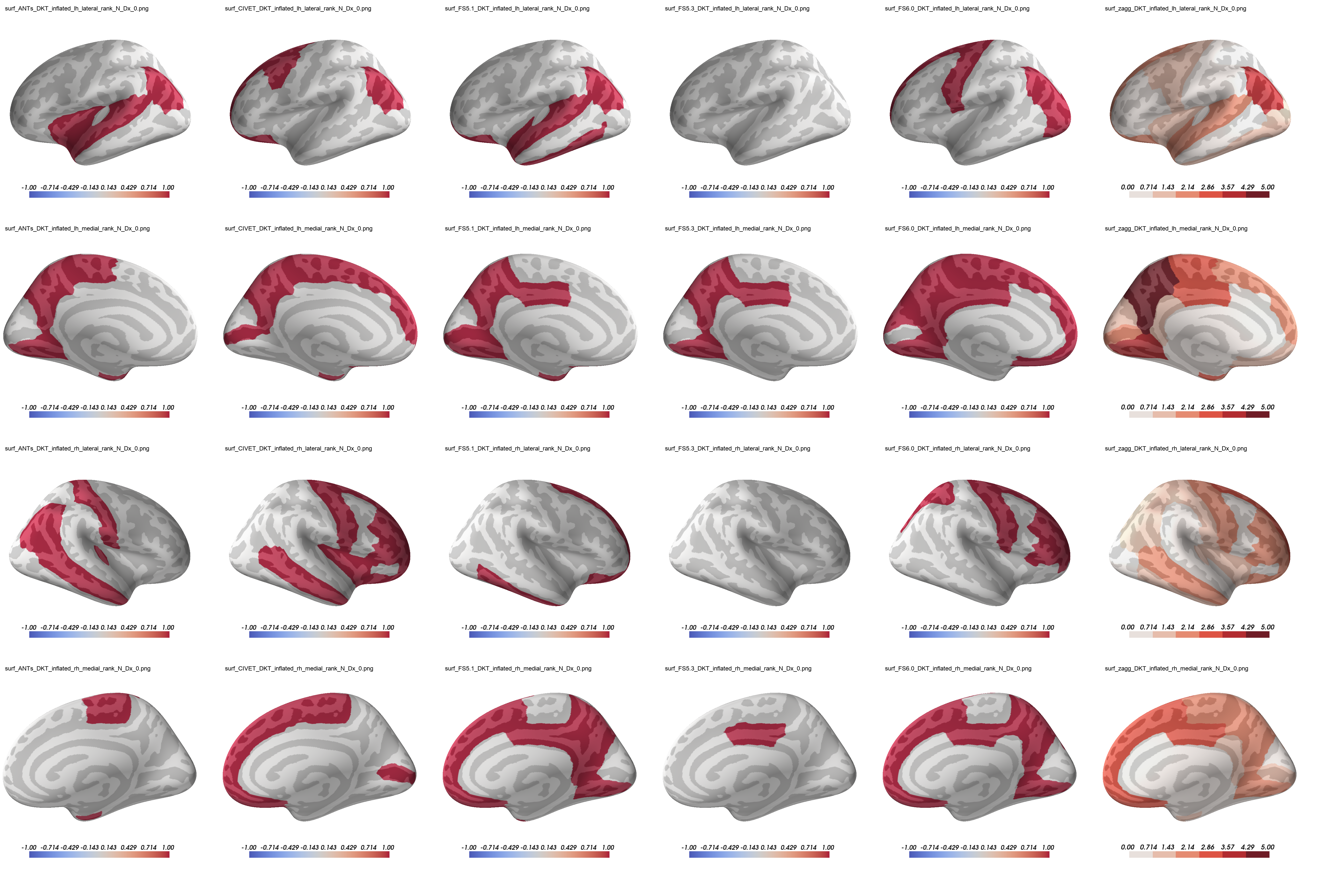

In [34]:
#plot_dir = brainmaps_dir + 'atlas_sm_perf_DX_GROUP_QC_gleb_FDR_N_225/'
plot_dir = save_dir
montage_im = createImageMontage(plot_dir)
montage_im

### Vertex plotting

In [5]:
# hemi = 'lh'
# view = 'medial'
N_signific = 500
analysis_type = 'clean'#either clean (OD) or comp (complete)
surf = 'inflated'
plot_dir = data_dir + 'outliers/highdim/visuals/'
save_path_template = plot_dir + 'test_brain_{}_{}.jpg'
aug_data = True

#cmap = plt.get_cmap('icefire'), #sns.diverging_palette(220, 10, as_cmap=True)
cmap = sns.xkcd_palette(["very light pink",'red']) 

analysis_files = ['coef_comp_con_{}','coef_clean_con_{}','coef_clean_con_him_{}']

for analysis_type in analysis_files:
    for hemi in ['lh','rh']:
        #input file
        f = 'df_index_{}.csv'.format(analysis_type).format(hemi) 
        sample_file = data_dir + 'outliers/highdim/{}'.format(f) 
        
        print('')
        print('Using outlier file: {}'.format(sample_file))

        sample_vdata = pd.read_csv(sample_file)
        for view in ['medial','lateral']:        
            #thickness_vals = np.max(sample_vdata.values[1:,1:], axis=0) #ignore header and index
            coef_data = sample_vdata['coef'].values
            N_nonzero = np.sum(coef_data != 0)
            N_signific_subset = np.min([N_signific, N_nonzero])
            coef_data_sorted_idx = coef_data.argsort()[-N_signific_subset:][::-1]
            print('Nonzero vertices avail {}, plotting {} '.format(N_nonzero, N_signific_subset))
            morph_data = np.zeros_like(coef_data)
            save_path = save_path_template.format(analysis_type.format(hemi),view)
            plot_surface_vertices(common_space,morph_data, coef_data_sorted_idx,aug_data,hemi,surf,view,cmap,save_path)


Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_lh.csv
Nonzero vertices avail 334, plotting 334 
Number of vertices to be plotted 334
Number of vertices to be plotted after augmentation 16700
5328.0
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/visuals/test_brain_coef_comp_con_lh_medial.jpg
Nonzero vertices avail 334, plotting 334 
Number of vertices to be plotted 334
Number of vertices to be plotted after augmentation 16700
5328.0
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/visuals/test_brain_coef_comp_con_lh_lateral.jpg

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_rh.csv
Nonzero vertices avail 421, plotting 421 
Number of vertices to be pl

Reading images from /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/visuals/
Found 12 images
montage size (880, 660)


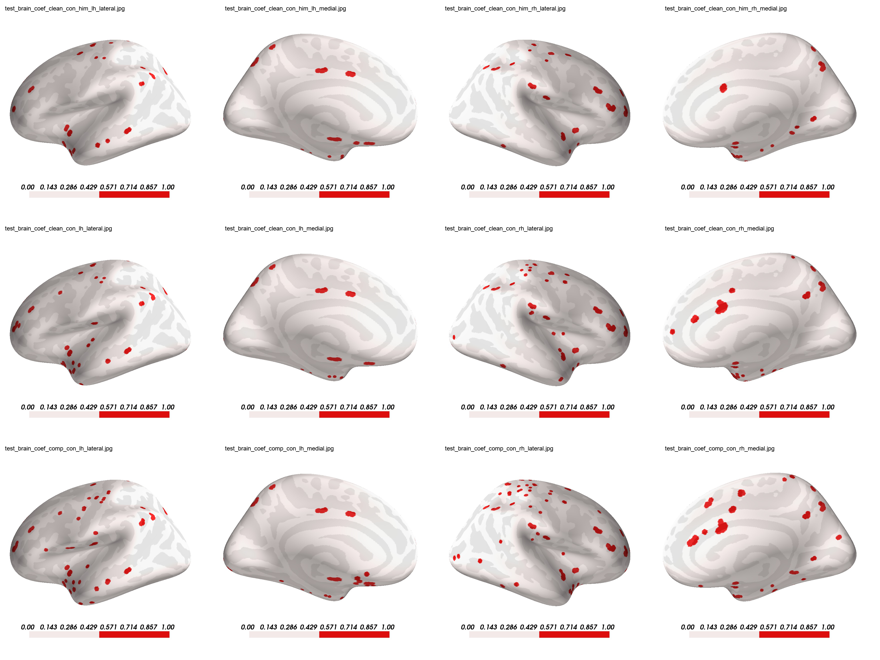

In [6]:
plot_dir = data_dir + 'outliers/highdim/visuals/'

montage_im = createImageMontage(plot_dir,num_img_views=4,transpose=True)
montage_im

### Get coordinate of top N significant ROIs

In [7]:
N_signific = 10
signific_df_concat = pd.DataFrame()
analysis_files = ['coef_comp_con_{}','coef_clean_con_{}','coef_clean_con_him_{}']
for analysis_type in analysis_files:
    for hemi in ['lh','rh']:
        #input file
        f = 'df_index_{}.csv'.format(analysis_type).format(hemi) 
        sample_file = data_dir + 'outliers/highdim/{}'.format(f) 
        
        print('')
        print('Using outlier file: {}'.format(sample_file))
        
        sample_vdata = pd.read_csv(sample_file)
        morph_data = np.abs(sample_vdata['coef'].values)
        morph_data_sorted_idx = morph_data.argsort()[-N_signific:][::-1]

        b = Brain(common_space, hemi, surf)
        x, y, z = b.geo[hemi].coords.T

        # ROI Labels
        aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],common_space, "label", hemi + '.aparc.annot')
        print('Using {} parcellation'.format(aparc_file))
        labels, ctab, names = nib.freesurfer.read_annot(aparc_file)
        signific_labels = labels[morph_data_sorted_idx]
        signific_names = np.array(names)[signific_labels]

        signific_df = pd.DataFrame()
        signific_df['idx'] = morph_data_sorted_idx + 1
        signific_df['x'],signific_df['y'],signific_df['z'] = x[morph_data_sorted_idx],y[morph_data_sorted_idx],z[morph_data_sorted_idx]
        signific_df['roi_idx'] = signific_labels
        signific_df['roi_name'] = signific_names
        signific_df['hemi'] = np.tile(hemi,len(signific_df))
        signific_df['samples'] = np.tile(analysis_type.format(hemi),len(signific_df))
        signific_df['coef'] = morph_data[morph_data_sorted_idx]

        signific_df_concat = signific_df_concat.append(signific_df)


Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_lh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaverage/label/lh.aparc.annot parcellation

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_rh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaverage/label/rh.aparc.annot parcellation

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_clean_con_lh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaverage/label/lh.aparc.annot parcellation

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_clean_con_rh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaver

In [8]:
signific_df_concat
#signific_df_concat.to_csv('/home/nikhil/Desktop/signficant_vertices_info_6files.csv')

,idx,x,y,z,roi_idx,roi_name,hemi,samples,coef
0,34551,-24.128948,-1.489648,41.427368,22,b'postcentral',lh,coef_comp_con_lh,0.592301
1,37490,34.087311,48.846249,20.897440,2,b'caudalanteriorcingulate',lh,coef_comp_con_lh,0.571519
2,18312,-23.381863,-5.907262,-4.400630,35,b'insula',lh,coef_comp_con_lh,0.561899
3,92570,3.463812,-10.150214,66.039818,24,b'precentral',lh,coef_comp_con_lh,0.554943
4,62112,28.030266,-55.648960,5.751086,25,b'precuneus',lh,coef_comp_con_lh,0.527958
5,143064,35.336605,-28.526398,4.935894,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.520918
6,62085,32.370636,-36.064564,18.484201,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.499091
7,25344,37.169491,-19.212038,9.191141,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.485607
8,48448,-21.969624,-3.662103,44.379936,22,b'postcentral',lh,coef_comp_con_lh,0.482522
9,120577,37.128284,-19.940786,8.086205,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.476712
